<h3>Two echelon supply chain network</h3>

We have implemented a two echelon supply chain network consisting of a supplier, a factory, a distributor and two customers. With this experiment we want to validate the manufacturer behavior in SupplNetPy.


In [1]:
# let us first import the libraries
# local import for convinience
import sys, os
sys.path.insert(1, '../src/SupplyNetPy/Components/')
import core as scm
import utilities as scm

In [2]:
"""
System description:

Product:
    Wireless Mouse
    Sell price = 300
    Cost = 150

Supplier:
    Infinite supply of a single product.
    location = 'Vasco'

Factory:
    location = 'Cansaulim'
    replenishment policy = mi-max (s,S); s = 800, S = 2500, initial level = 800
    Inventory holding cost = 0.1
    trasportation cost = 10
    lead time = 1 days

Distrubution Center:
    location = 'Margao'
    replenishment policy = mi-max (s,S); s = 500, S = 1000, initial level = 1000
    Inventory holding cost = 0.22

customers:
    location = 'Varca', order interval = 1 day, order size = 23, lead time = 1 day, delivery cost = 10  
    location = 'Paroda', order interval = 1 day, order size = 35, lead time = 1 day delivery cost = 10

"""

import simpy
import numpy as np
import matplotlib.pyplot as plt

env = simpy.Environment()

raw_mat = scm.RawMaterial(ID="RM1", name="raw materials mouse", extraction_quantity=2500, 
                          extraction_time=1, mining_cost=0.01, cost=150) 

supplier = scm.Supplier(env=env, ID='S1', name='Supplier', node_type="infinite_supplier", raw_material=raw_mat)

mouse = scm.Product(ID="MW11", name="Toad M11", manufacturing_cost=150, 
                             manufacturing_time=0, sell_price=300, buy_price=150,
                             raw_materials=[{"raw_material": raw_mat, "quantity": 1}], units_per_cycle=2500)

factory = scm.Manufacturer(env=env, ID='F1', name='Factory Cansaulim', capacity=2500, initial_level=800, 
                           inventory_holding_cost=0.1, replenishment_policy="sS", policy_param=[800], 
                           product=mouse, product_sell_price=300)

distributor = scm.InventoryNode(env=env, ID='D1', name='Margao DC', node_type="warehouse", 
                                capacity=1000, initial_level=1000, inventory_holding_cost=0.22, product=mouse,
                                replenishment_policy="sS", policy_param=[500], product_sell_price=300)

link1 = scm.Link(env=env, ID='L1', source=supplier, sink=factory, cost=10, lead_time=lambda: 0)
link2 = scm.Link(env=env, ID='L2', source=factory, sink=distributor, cost=10, lead_time=lambda: 1)

demand1 = scm.Demand(env=env, ID='d1', name='Varca', order_arrival_model = lambda: 1, order_quantity_model=lambda: 23,
                     lead_time=lambda: 0.9, delivery_cost=lambda: 10, demand_node=distributor)
demand2 = scm.Demand(env=env, ID='d2', name='Paroda', order_arrival_model = lambda: 1, order_quantity_model=lambda: 35,
                     lead_time=lambda: 0.9, delivery_cost=lambda: 10, demand_node=distributor)

env.run(until=59)

INFO sim_trace - 0.0000:d1:Customer0:Demand at Margao DC, Order quantity:23, available.
INFO sim_trace - 0.0000:d2:Customer0:Demand at Margao DC, Order quantity:35, available.
INFO sim_trace - 0.9000:d1:Customer0:Demand at Margao DC, Order quantity:23 received. Current inv: 942
INFO sim_trace - 0.9000:d2:Customer0:Demand at Margao DC, Order quantity:35 received. Current inv: 942
INFO sim_trace - 0.9990:D1: Inventory levels:942
INFO sim_trace - 0.9999:F1: Raw materials' inventory levels:{'RM1': 0}, Product inventory levels:800
INFO sim_trace - 0.9999:F1:Replenishing raw material:raw materials mouse from supplier:S1, order placed for 1700 units.
INFO sim_trace - 0.9999:F1:shipment in transit from supplier:Supplier.
INFO sim_trace - 0.9999:F1:Order received from supplier:Supplier, inventory levels: {'RM1': 1700}
INFO sim_trace - 1.0000:F1: 1700 units manufactured.
INFO sim_trace - 1.0000:F1: Product inventory levels:2500
INFO sim_trace - 1.0000:d1:Customer1:Demand at Margao DC, Order quan

Performance:
	Available Inventory: [1456, 710], Total = 2166
	Inventory cost: [10456.199999999997, 9343.399999999996], Total = 19799.59999999999
	Inventory Spend: [568200, 939600], Total = 1507800
	Transportation cost: [20, 60, 590, 590], Total = 1260
	Total cost: [578676.2, 949003.4, 590, 590], Total = 1528859.6
	Total #products sold: [1357, 2065], Total = 3422
	Sell price: 300
	Total revenue: 1026600
	Net profit (Totalcost - Revenue): -502259.6000000001


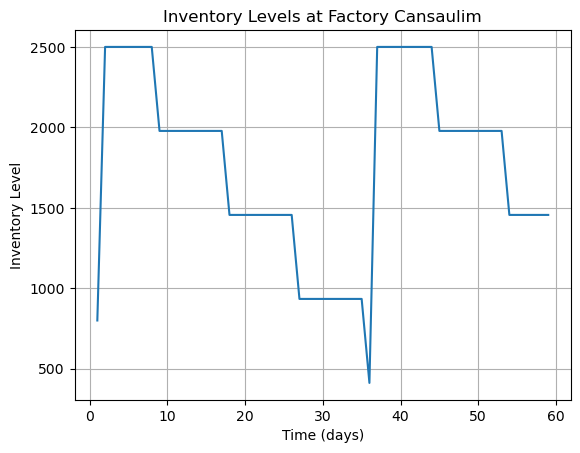

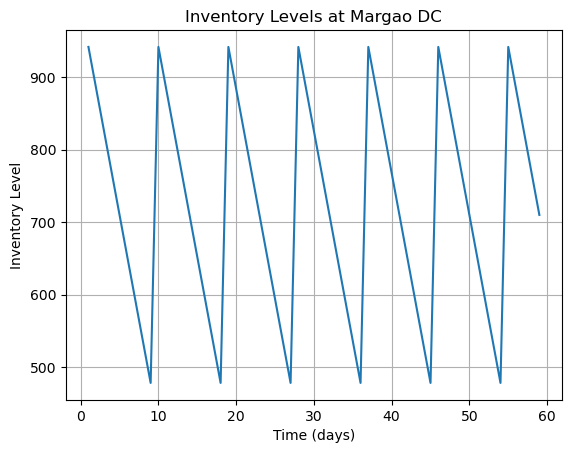

In [3]:
nodes = [factory, distributor]
demands = [demand1, demand2]

available_inventory = []
inventory_costs = []
inventory_spends = []
tranportation_costs = []
total_costs = []
total_units_sold = []

for node in nodes:
    available_inventory.append(node.inventory.inventory.level)
    inventory_costs.append(node.inventory_cost)
    inventory_spends.append(sum([x[1] for x in node.inventory.inventory_spend]))
    tranportation_costs.append(sum([x[1] for x in node.transportation_cost]))
    total_costs.append(node.node_cost)

for demand in demands:
    if(demand.transportation_cost):
        tranportation_costs.append(demand.node_cost)
        total_units_sold.append(demand.total_products_sold)
        total_costs.append(demand.node_cost)


print(f"Performance:")
print(f"\tAvailable Inventory: {available_inventory}, Total = {sum(available_inventory)}")
print(f"\tInventory cost: {inventory_costs}, Total = {sum(inventory_costs)}")
print(f"\tInventory Spend: {inventory_spends}, Total = {sum(inventory_spends)}")
print(f"\tTransportation cost: {tranportation_costs}, Total = {sum(tranportation_costs)}")

print(f"\tTotal cost: {total_costs}, Total = {sum(total_costs)}")
print(f"\tTotal #products sold: {total_units_sold}, Total = {sum(total_units_sold)}")
print(f"\tSell price: {mouse.sell_price}")
revenue = sum(total_units_sold) * mouse.sell_price
print(f"\tTotal revenue: {revenue}")
print(f"\tNet profit (Totalcost - Revenue): {revenue - sum(total_costs)}")

for node in nodes:
    inv_levels = np.array(node.inventory.instantaneous_levels)
    plt.plot(inv_levels[:,0],inv_levels[:,1], label=node.name)
    plt.title(f'Inventory Levels at {node.name}')
    plt.xlabel('Time (days)')
    plt.ylabel('Inventory Level')
    plt.grid() # add grid
    plt.show()